In [19]:
import glob
import cv2
from matplotlib.pyplot import figure
import keras
from keras import backend as K, layers
from keras.losses import mse
from keras import layers
import numpy as np
from keras.api import keras
import tensorflow as tf
from matplotlib import pyplot as plt
import os

IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512
LATENT_SIZE = 128
EPOCHS = 100
AE_PATH = './ae'
VAE_PATH = './vae'
WGAN_PATH = './wgan'

fashion_mnist = keras.datasets.fashion_mnist
(train_images, _), _ = fashion_mnist.load_data()
train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float64")
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
dataset = tf.data.Dataset.from_tensor_slices((train_images - 127.5) / 127.5)
dataset = dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)

Number of examples: 60000
Shape of the images in the dataset: (28, 28)


In [2]:
def conv_block(
        x,
        filters,
        activation,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding="same",
        use_bias=True,
        use_bn=False,
        use_dropout=False,
        drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def upsample_block(
        x,
        filters,
        activation,
        kernel_size=(3, 3),
        strides=(1, 1),
        up_size=(2, 2),
        padding="same",
        use_bn=False,
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit
# Not used, ran out of time :(
def residual_block(x, kernel_size, filters):
    fx = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv2D(filters, kernel_size, padding='same')(fx)
    out = layers.Add()([x, fx])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)
    return out

In [3]:
def encoder_block(input_layer):
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(input_layer)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)

    return x

In [4]:
def generative_model(latent_size):
    noise = layers.Input(shape=(latent_size,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = layers.Cropping2D((2, 2))(x)

    return keras.models.Model(noise, x, name="generator")

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        # override the inherited .call(self, inputs) method
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))  # N(0, 1)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # N(mu, sigma)


def get_autoencoder(img_shape, latent_size, generator, variable=False):
    img_input = layers.Input(shape=img_shape)
    x = encoder_block(img_input)
    if variable:
        z_mean = layers.Dense(latent_size, name="z_mean")(x)
        z_log_var = layers.Dense(latent_size, name="z_log_var")(x)
        z = Sampling()((z_mean, z_log_var))
    else:
        z = layers.Dense(latent_size, name="z")(x)
    encoder = keras.models.Model(img_input, z, name="encoder")
    outputs = generator(z)
    ae = keras.models.Model(img_input, outputs, name="autoencoder")

    # Loss approach from
    # https://gist.github.com/tik0/6aa42cabb9cf9e21567c3deb309107b7
    reconstruction_loss = mse(img_input, outputs)  # xhat should match x
    reconstruction_loss = 784 * K.mean(reconstruction_loss)
    if variable:
        variable = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        ae.add_loss(variable)
        ae.add_metric(variable, name='kl_loss', aggregation='mean')

    # Set up our losses on the model, and create them as metrics too.
    # The Model's loss is the sum of the two losses.
    ae.add_loss(reconstruction_loss)
    ae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

    return ae, encoder

In [22]:
class WGAN(keras.Model):
    def __init__(
        self,
        img_shape,
        latent_size,
        generator,
        generator_optimizer,
        discriminator_optimizer,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = self.get_discriminator(img_shape)
        self.discriminator.summary()
        self.generator = generator
        self.latent_size = latent_size
        self.discriminator_steps = discriminator_extra_steps
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.gradient_penalty_weight = gp_weight

    def get_discriminator(self, shape):
        img_input = layers.Input(shape=shape)
        x = encoder_block(img_input)
        x = layers.Dense(1)(x)
        return keras.models.Model(img_input, x, name="discriminator")

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def generator_loss(self, fake_img):
        return -tf.reduce_mean(fake_img)

    def discriminator_loss(self, real_img, fake_img):
        real_loss = tf.reduce_mean(real_img)
        fake_loss = tf.reduce_mean(fake_img)
        return fake_loss - real_loss

    def compile(self):
        super(WGAN, self).compile()

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.discriminator_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_size)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.discriminator_loss(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gradient_penalty_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.discriminator_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_size))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.generator_loss(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.generator_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [7]:
class ModelMonitor(keras.callbacks.Callback):
    def __init__(self, generator, img_shape, latent_size, path, size, show_frequency=1):
        super().__init__()
        self.show_frequency = show_frequency
        self.size = size
        self.generator = generator
        self.img_shape = img_shape
        self.latent_size = latent_size
        self.path = path
        os.makedirs(path, exist_ok=True)
        os.makedirs(path + '/epochs', exist_ok=True)
        os.makedirs(path + '/checkpoints', exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.size * self.size, self.latent_size))
        generated_images = self.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5
        grid = np.array(generated_images)
        grid = (
            grid.reshape(self.size, self.size, self.img_shape[0], self.img_shape[0])
                .swapaxes(1, 2)
                .reshape(self.img_shape[0] * self.size, self.img_shape[0] * self.size)
        )
        plt.figure(figsize=(8, 8))
        plt.imsave('{}/epochs/{}.png'.format(self.path, epoch), grid, cmap='gray', vmin=0, vmax=255)
        if epoch % self.show_frequency == 0:
            plt.imshow(grid, cmap='gray', vmin=0, vmax=255)
            plt.show()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 32, 32, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   1664        ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)      (None, 16, 16, 64)   0           ['conv2d_3[0][0]']               
                                                                                        

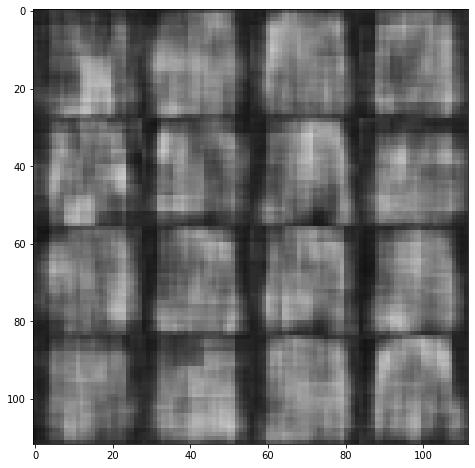

118/118 [==============================] - 51s 307ms/step - loss: 107.4888 - mse_loss: 107.4888
Epoch 2/100
118/118 [==============================] - 35s 300ms/step - loss: 58.2289 - mse_loss: 58.2289
Epoch 3/100
118/118 [==============================] - 35s 300ms/step - loss: 44.8076 - mse_loss: 44.8076
Epoch 4/100
118/118 [==============================] - 35s 300ms/step - loss: 37.6732 - mse_loss: 37.6732
Epoch 5/100
118/118 [==============================] - 36s 300ms/step - loss: 33.4233 - mse_loss: 33.4233
Epoch 6/100
118/118 [==============================] - 35s 300ms/step - loss: 30.0573 - mse_loss: 30.0573
Epoch 7/100
118/118 [==============================] - 35s 300ms/step - loss: 27.6400 - mse_loss: 27.6400
Epoch 8/100
118/118 [==============================] - 35s 300ms/step - loss: 25.7784 - mse_loss: 25.7784
Epoch 9/100
118/118 [==============================] - 35s 300ms/step - loss: 24.3718 - mse_loss: 24.3718
Epoch 10/100
118/118 [==============================] - 

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

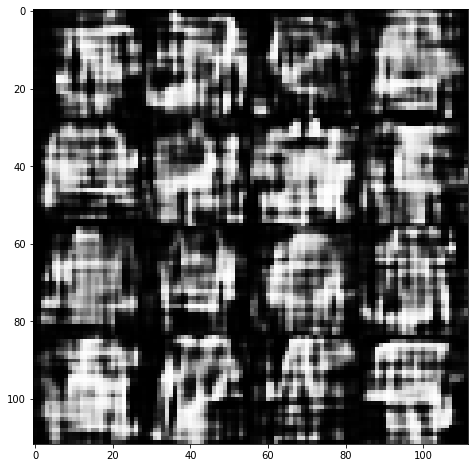

118/118 [==============================] - 36s 302ms/step - loss: 22.3238 - mse_loss: 22.3238
Epoch 12/100
118/118 [==============================] - 35s 299ms/step - loss: 21.3238 - mse_loss: 21.3238
Epoch 13/100
118/118 [==============================] - 35s 300ms/step - loss: 20.7356 - mse_loss: 20.7356
Epoch 14/100
118/118 [==============================] - 35s 299ms/step - loss: 20.1563 - mse_loss: 20.1563
Epoch 15/100
118/118 [==============================] - 35s 300ms/step - loss: 19.5410 - mse_loss: 19.5410
Epoch 16/100
118/118 [==============================] - 35s 300ms/step - loss: 19.0198 - mse_loss: 19.0198
Epoch 17/100
118/118 [==============================] - 35s 300ms/step - loss: 18.6452 - mse_loss: 18.6452
Epoch 18/100
118/118 [==============================] - 35s 299ms/step - loss: 18.1751 - mse_loss: 18.1751
Epoch 19/100
118/118 [==============================] - 35s 299ms/step - loss: 17.7480 - mse_loss: 17.7480
Epoch 20/100
118/118 [============================

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

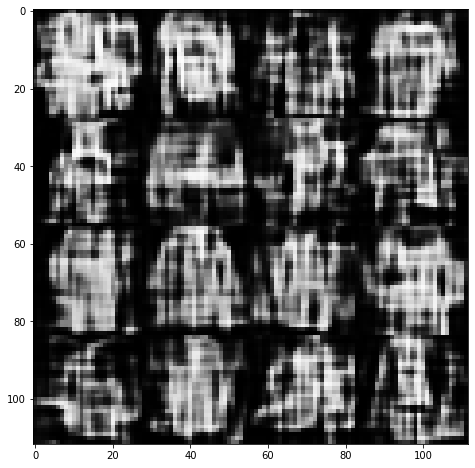

118/118 [==============================] - 36s 301ms/step - loss: 17.4243 - mse_loss: 17.4243
Epoch 22/100
118/118 [==============================] - 35s 300ms/step - loss: 17.1846 - mse_loss: 17.1846
Epoch 23/100
118/118 [==============================] - 35s 300ms/step - loss: 16.6533 - mse_loss: 16.6533
Epoch 24/100
118/118 [==============================] - 35s 300ms/step - loss: 16.6364 - mse_loss: 16.6364
Epoch 25/100
118/118 [==============================] - 35s 300ms/step - loss: 16.2079 - mse_loss: 16.2079
Epoch 26/100
118/118 [==============================] - 35s 299ms/step - loss: 16.1725 - mse_loss: 16.1725
Epoch 27/100
118/118 [==============================] - 35s 300ms/step - loss: 15.9304 - mse_loss: 15.9304
Epoch 28/100
118/118 [==============================] - 35s 299ms/step - loss: 15.9477 - mse_loss: 15.9477
Epoch 29/100
118/118 [==============================] - 35s 300ms/step - loss: 15.7822 - mse_loss: 15.7822
Epoch 30/100
118/118 [============================

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

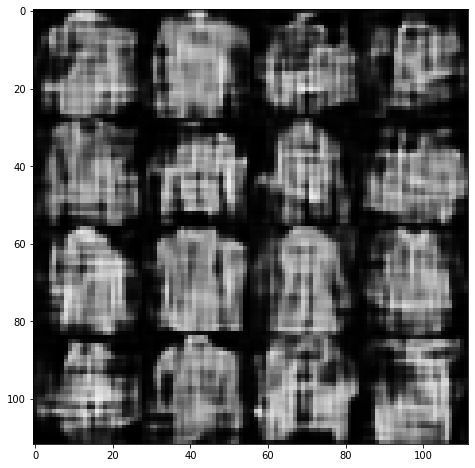

118/118 [==============================] - 35s 300ms/step - loss: 15.3352 - mse_loss: 15.3352
Epoch 32/100
118/118 [==============================] - 35s 299ms/step - loss: 15.3070 - mse_loss: 15.3070
Epoch 33/100
118/118 [==============================] - 35s 299ms/step - loss: 15.2634 - mse_loss: 15.2634
Epoch 34/100
118/118 [==============================] - 35s 299ms/step - loss: 14.9714 - mse_loss: 14.9714
Epoch 35/100
118/118 [==============================] - 35s 299ms/step - loss: 14.8506 - mse_loss: 14.8506
Epoch 36/100
118/118 [==============================] - 35s 300ms/step - loss: 14.8302 - mse_loss: 14.8302
Epoch 37/100
118/118 [==============================] - 35s 299ms/step - loss: 14.7212 - mse_loss: 14.7212
Epoch 38/100
118/118 [==============================] - 35s 299ms/step - loss: 14.5793 - mse_loss: 14.5793
Epoch 39/100
118/118 [==============================] - 35s 299ms/step - loss: 14.4811 - mse_loss: 14.4811
Epoch 40/100
118/118 [============================

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

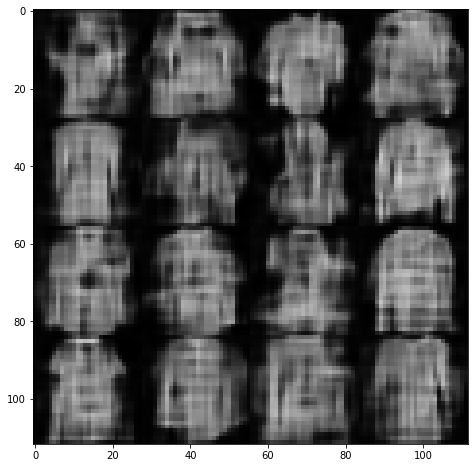

118/118 [==============================] - 36s 302ms/step - loss: 14.4116 - mse_loss: 14.4116
Epoch 42/100
118/118 [==============================] - 35s 299ms/step - loss: 14.2520 - mse_loss: 14.2520
Epoch 43/100
118/118 [==============================] - 35s 299ms/step - loss: 14.1123 - mse_loss: 14.1123
Epoch 44/100
118/118 [==============================] - 35s 299ms/step - loss: 14.2392 - mse_loss: 14.2392
Epoch 45/100
118/118 [==============================] - 35s 300ms/step - loss: 14.2140 - mse_loss: 14.2140
Epoch 46/100
118/118 [==============================] - 35s 300ms/step - loss: 14.0355 - mse_loss: 14.0355
Epoch 47/100
118/118 [==============================] - 35s 300ms/step - loss: 13.9934 - mse_loss: 13.9934
Epoch 48/100
118/118 [==============================] - 35s 300ms/step - loss: 13.9579 - mse_loss: 13.9579
Epoch 49/100
118/118 [==============================] - 35s 299ms/step - loss: 13.9238 - mse_loss: 13.9238
Epoch 50/100
118/118 [============================

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

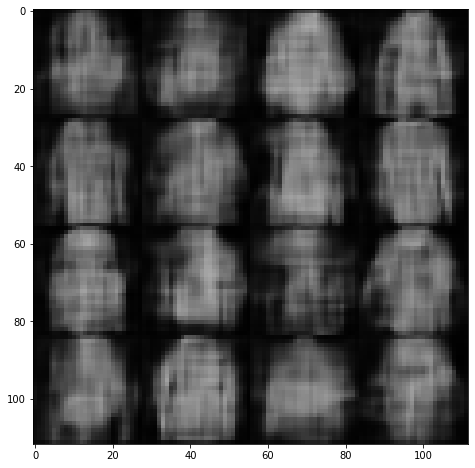

118/118 [==============================] - 36s 301ms/step - loss: 13.6062 - mse_loss: 13.6062
Epoch 52/100
118/118 [==============================] - 35s 299ms/step - loss: 13.5948 - mse_loss: 13.5948
Epoch 53/100
118/118 [==============================] - 35s 299ms/step - loss: 13.5852 - mse_loss: 13.5852
Epoch 54/100
118/118 [==============================] - 35s 299ms/step - loss: 13.6166 - mse_loss: 13.6166
Epoch 55/100
118/118 [==============================] - 35s 300ms/step - loss: 13.5405 - mse_loss: 13.5405
Epoch 56/100
118/118 [==============================] - 35s 299ms/step - loss: 13.5945 - mse_loss: 13.5945
Epoch 57/100
118/118 [==============================] - 35s 299ms/step - loss: 13.3598 - mse_loss: 13.3598
Epoch 58/100
118/118 [==============================] - 35s 300ms/step - loss: 13.2745 - mse_loss: 13.2745
Epoch 59/100
118/118 [==============================] - 35s 300ms/step - loss: 13.3205 - mse_loss: 13.3205
Epoch 60/100
118/118 [============================

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

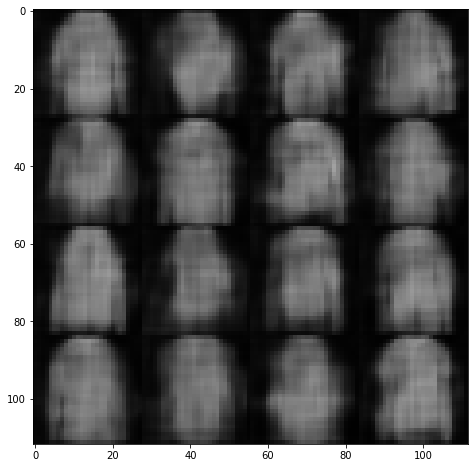

118/118 [==============================] - 36s 301ms/step - loss: 13.2068 - mse_loss: 13.2068
Epoch 62/100
118/118 [==============================] - 35s 299ms/step - loss: 13.2385 - mse_loss: 13.2385
Epoch 63/100
118/118 [==============================] - 35s 300ms/step - loss: 13.0985 - mse_loss: 13.0985
Epoch 64/100
118/118 [==============================] - 35s 300ms/step - loss: 12.9914 - mse_loss: 12.9914
Epoch 65/100
118/118 [==============================] - 36s 300ms/step - loss: 12.9736 - mse_loss: 12.9736
Epoch 66/100
118/118 [==============================] - 35s 300ms/step - loss: 13.0533 - mse_loss: 13.0533
Epoch 67/100
118/118 [==============================] - 35s 299ms/step - loss: 12.9633 - mse_loss: 12.9633
Epoch 68/100
118/118 [==============================] - 36s 299ms/step - loss: 12.8838 - mse_loss: 12.8838
Epoch 69/100
118/118 [==============================] - 35s 299ms/step - loss: 12.9431 - mse_loss: 12.9431
Epoch 70/100
118/118 [============================

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

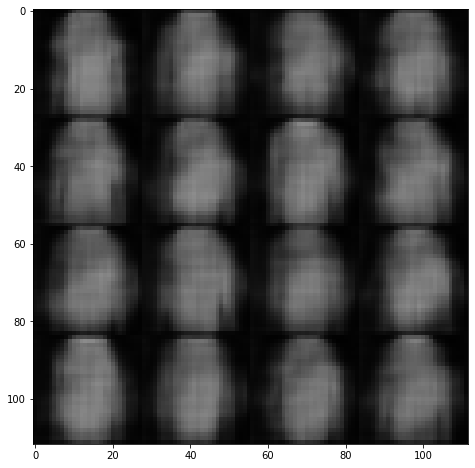

118/118 [==============================] - 36s 302ms/step - loss: 12.8212 - mse_loss: 12.8212
Epoch 72/100
118/118 [==============================] - 35s 299ms/step - loss: 12.9460 - mse_loss: 12.9460
Epoch 73/100
118/118 [==============================] - 35s 299ms/step - loss: 12.7697 - mse_loss: 12.7697
Epoch 74/100
118/118 [==============================] - 35s 300ms/step - loss: 12.7832 - mse_loss: 12.7832
Epoch 75/100
118/118 [==============================] - 35s 300ms/step - loss: 12.7645 - mse_loss: 12.7645
Epoch 76/100
118/118 [==============================] - 35s 299ms/step - loss: 12.7155 - mse_loss: 12.7155
Epoch 77/100
118/118 [==============================] - 35s 299ms/step - loss: 12.6758 - mse_loss: 12.6758
Epoch 78/100
118/118 [==============================] - 35s 299ms/step - loss: 12.6079 - mse_loss: 12.6079
Epoch 79/100
118/118 [==============================] - 35s 300ms/step - loss: 12.5467 - mse_loss: 12.5467
Epoch 80/100
118/118 [============================

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

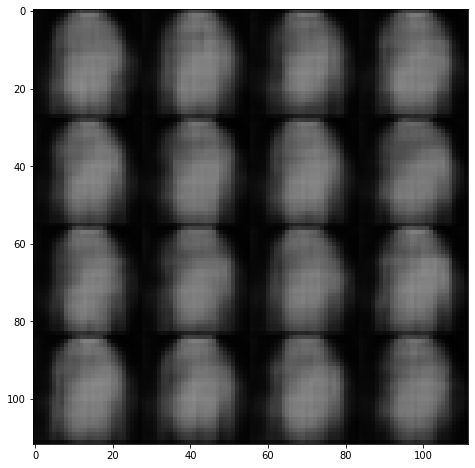

118/118 [==============================] - 36s 302ms/step - loss: 12.5548 - mse_loss: 12.5548
Epoch 82/100
118/118 [==============================] - 35s 299ms/step - loss: 12.4271 - mse_loss: 12.4271
Epoch 83/100
118/118 [==============================] - 35s 299ms/step - loss: 12.4741 - mse_loss: 12.4741
Epoch 84/100
118/118 [==============================] - 35s 300ms/step - loss: 12.4496 - mse_loss: 12.4496
Epoch 85/100
118/118 [==============================] - 35s 300ms/step - loss: 12.5438 - mse_loss: 12.5438
Epoch 86/100
118/118 [==============================] - 35s 299ms/step - loss: 12.4483 - mse_loss: 12.4483
Epoch 87/100
118/118 [==============================] - 35s 299ms/step - loss: 12.4530 - mse_loss: 12.4530
Epoch 88/100
118/118 [==============================] - 35s 299ms/step - loss: 12.4282 - mse_loss: 12.4282
Epoch 89/100
118/118 [==============================] - 35s 299ms/step - loss: 12.3744 - mse_loss: 12.3744
Epoch 90/100
118/118 [============================

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

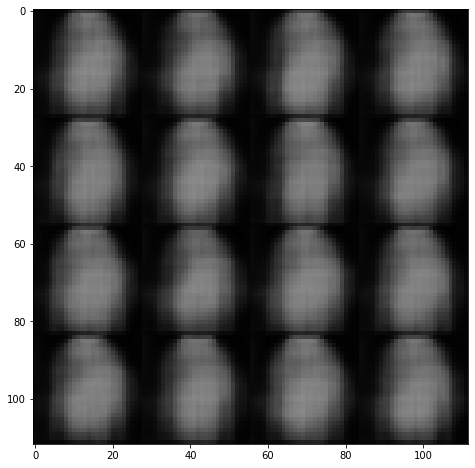

118/118 [==============================] - 36s 302ms/step - loss: 12.2751 - mse_loss: 12.2751
Epoch 92/100
118/118 [==============================] - 35s 299ms/step - loss: 12.1773 - mse_loss: 12.1773
Epoch 93/100
118/118 [==============================] - 35s 300ms/step - loss: 12.3106 - mse_loss: 12.3106
Epoch 94/100
118/118 [==============================] - 35s 300ms/step - loss: 12.2248 - mse_loss: 12.2248
Epoch 95/100
118/118 [==============================] - 35s 299ms/step - loss: 12.2242 - mse_loss: 12.2242
Epoch 96/100
118/118 [==============================] - 35s 299ms/step - loss: 12.2280 - mse_loss: 12.2280
Epoch 97/100
118/118 [==============================] - 35s 300ms/step - loss: 12.2058 - mse_loss: 12.2058
Epoch 98/100
118/118 [==============================] - 35s 300ms/step - loss: 12.1187 - mse_loss: 12.1187
Epoch 99/100
118/118 [==============================] - 35s 299ms/step - loss: 12.1336 - mse_loss: 12.1336
Epoch 100/100
118/118 [===========================

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [ ]:
# AE Method =================================================================
EPOCHS = 100
generator = generative_model(LATENT_SIZE)
ae_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
ae, encoder = get_autoencoder(IMG_SHAPE, LATENT_SIZE, generator)
ae.compile(ae_optimizer)
ae.summary()
callback = ModelMonitor(generator, IMG_SHAPE, LATENT_SIZE, AE_PATH, 4, 10)
ae.fit(dataset, callbacks=[callback], epochs=EPOCHS)

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 32, 32, 1)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 64)   1664        ['zero_padding2d_1[0][0]']       
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     (None, 16, 16, 64)   0           ['conv2d_10[0][0]']    

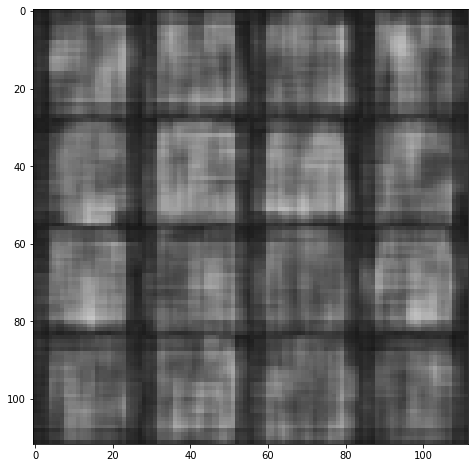

118/118 [==============================] - 37s 301ms/step - loss: 112.3796 - kl_loss: 2.8108 - mse_loss: 109.5688
Epoch 2/100
118/118 [==============================] - 35s 299ms/step - loss: 56.6778 - kl_loss: 1.9863 - mse_loss: 54.6916
Epoch 3/100
118/118 [==============================] - 35s 299ms/step - loss: 44.7351 - kl_loss: 2.0492 - mse_loss: 42.6859
Epoch 4/100
118/118 [==============================] - 35s 300ms/step - loss: 37.9019 - kl_loss: 2.0935 - mse_loss: 35.8085
Epoch 5/100
118/118 [==============================] - 35s 300ms/step - loss: 33.5560 - kl_loss: 2.1245 - mse_loss: 31.4315
Epoch 6/100
118/118 [==============================] - 35s 300ms/step - loss: 30.5262 - kl_loss: 2.1508 - mse_loss: 28.3755
Epoch 7/100
118/118 [==============================] - 35s 299ms/step - loss: 28.6043 - kl_loss: 2.1668 - mse_loss: 26.4374
Epoch 8/100
118/118 [==============================] - 35s 300ms/step - loss: 26.8691 - kl_loss: 2.1736 - mse_loss: 24.6955
Epoch 9/100
118/11

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

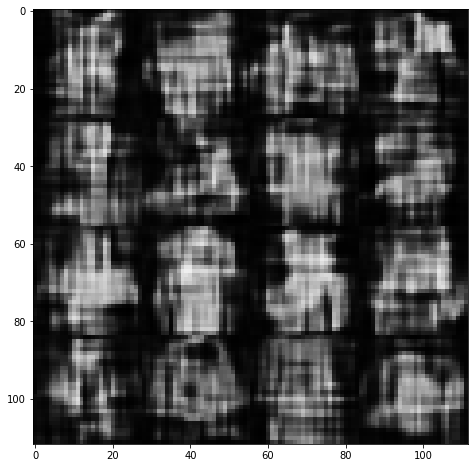

118/118 [==============================] - 36s 302ms/step - loss: 23.8302 - kl_loss: 2.1940 - mse_loss: 21.6362
Epoch 12/100
118/118 [==============================] - 35s 299ms/step - loss: 23.2546 - kl_loss: 2.2048 - mse_loss: 21.0498
Epoch 13/100
118/118 [==============================] - 35s 300ms/step - loss: 22.4027 - kl_loss: 2.2001 - mse_loss: 20.2026
Epoch 14/100
118/118 [==============================] - 35s 300ms/step - loss: 22.0212 - kl_loss: 2.2045 - mse_loss: 19.8167
Epoch 15/100
118/118 [==============================] - 35s 300ms/step - loss: 21.5763 - kl_loss: 2.2121 - mse_loss: 19.3641
Epoch 16/100
118/118 [==============================] - 35s 300ms/step - loss: 21.1420 - kl_loss: 2.2129 - mse_loss: 18.9291
Epoch 17/100
118/118 [==============================] - 35s 300ms/step - loss: 20.4722 - kl_loss: 2.2058 - mse_loss: 18.2664
Epoch 18/100
118/118 [==============================] - 35s 300ms/step - loss: 20.3140 - kl_loss: 2.2153 - mse_loss: 18.0987
Epoch 19/100


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

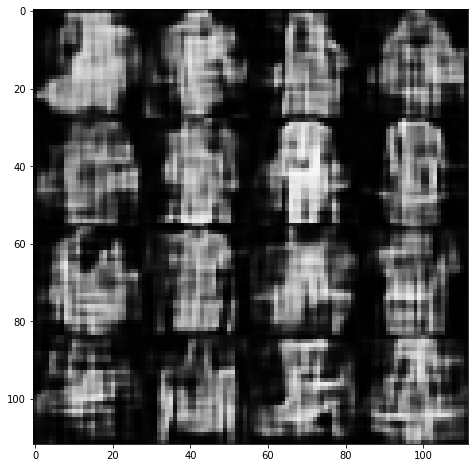

118/118 [==============================] - 36s 302ms/step - loss: 19.3670 - kl_loss: 2.2130 - mse_loss: 17.1539
Epoch 22/100
118/118 [==============================] - 36s 300ms/step - loss: 19.2917 - kl_loss: 2.2148 - mse_loss: 17.0769
Epoch 23/100
118/118 [==============================] - 35s 299ms/step - loss: 18.9565 - kl_loss: 2.2153 - mse_loss: 16.7411
Epoch 24/100
118/118 [==============================] - 35s 299ms/step - loss: 18.9322 - kl_loss: 2.2165 - mse_loss: 16.7157
Epoch 25/100
118/118 [==============================] - 35s 300ms/step - loss: 18.5782 - kl_loss: 2.2097 - mse_loss: 16.3685
Epoch 26/100
118/118 [==============================] - 35s 299ms/step - loss: 18.3949 - kl_loss: 2.2109 - mse_loss: 16.1840
Epoch 27/100
118/118 [==============================] - 35s 299ms/step - loss: 18.2397 - kl_loss: 2.2123 - mse_loss: 16.0274
Epoch 28/100
118/118 [==============================] - 35s 300ms/step - loss: 18.0857 - kl_loss: 2.2078 - mse_loss: 15.8779
Epoch 29/100


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

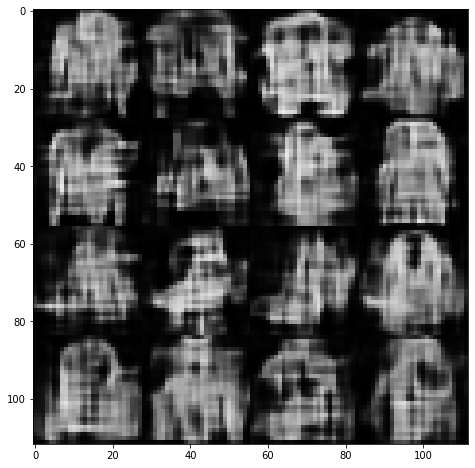

118/118 [==============================] - 36s 302ms/step - loss: 17.7825 - kl_loss: 2.2067 - mse_loss: 15.5758
Epoch 32/100
118/118 [==============================] - 35s 300ms/step - loss: 17.7566 - kl_loss: 2.2070 - mse_loss: 15.5496
Epoch 33/100
118/118 [==============================] - 35s 300ms/step - loss: 17.5421 - kl_loss: 2.2041 - mse_loss: 15.3380
Epoch 34/100
118/118 [==============================] - 35s 300ms/step - loss: 17.5891 - kl_loss: 2.2067 - mse_loss: 15.3824
Epoch 35/100
118/118 [==============================] - 35s 299ms/step - loss: 17.4808 - kl_loss: 2.2031 - mse_loss: 15.2776
Epoch 36/100
118/118 [==============================] - 35s 300ms/step - loss: 17.3055 - kl_loss: 2.2021 - mse_loss: 15.1033
Epoch 37/100
118/118 [==============================] - 35s 300ms/step - loss: 17.2745 - kl_loss: 2.1988 - mse_loss: 15.0757
Epoch 38/100
118/118 [==============================] - 35s 300ms/step - loss: 17.2441 - kl_loss: 2.2026 - mse_loss: 15.0415
Epoch 39/100


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

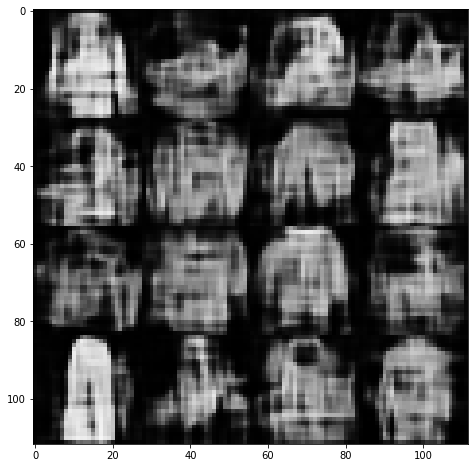

118/118 [==============================] - 36s 302ms/step - loss: 16.8613 - kl_loss: 2.1966 - mse_loss: 14.6646
Epoch 42/100
118/118 [==============================] - 35s 299ms/step - loss: 16.9300 - kl_loss: 2.2012 - mse_loss: 14.7288
Epoch 43/100
118/118 [==============================] - 35s 300ms/step - loss: 16.8986 - kl_loss: 2.2005 - mse_loss: 14.6981
Epoch 44/100
118/118 [==============================] - 35s 300ms/step - loss: 16.6800 - kl_loss: 2.1944 - mse_loss: 14.4857
Epoch 45/100
118/118 [==============================] - 35s 300ms/step - loss: 16.7757 - kl_loss: 2.1979 - mse_loss: 14.5778
Epoch 46/100
118/118 [==============================] - 36s 300ms/step - loss: 16.7189 - kl_loss: 2.1993 - mse_loss: 14.5196
Epoch 47/100
118/118 [==============================] - 35s 300ms/step - loss: 16.6809 - kl_loss: 2.1975 - mse_loss: 14.4834
Epoch 48/100
118/118 [==============================] - 35s 300ms/step - loss: 16.5444 - kl_loss: 2.1961 - mse_loss: 14.3483
Epoch 49/100


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

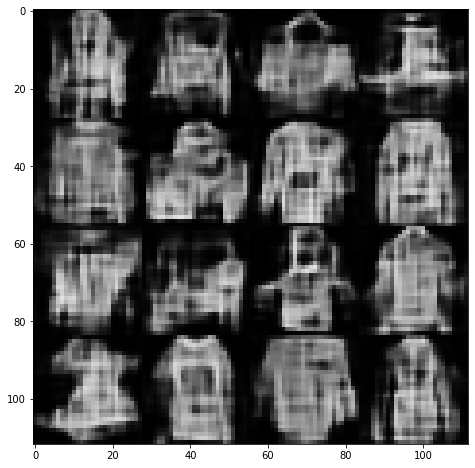

118/118 [==============================] - 36s 302ms/step - loss: 16.3907 - kl_loss: 2.1923 - mse_loss: 14.1984
Epoch 52/100
118/118 [==============================] - 35s 300ms/step - loss: 16.2173 - kl_loss: 2.1877 - mse_loss: 14.0296
Epoch 53/100
118/118 [==============================] - 35s 300ms/step - loss: 16.2444 - kl_loss: 2.1885 - mse_loss: 14.0559
Epoch 54/100
118/118 [==============================] - 35s 299ms/step - loss: 16.2203 - kl_loss: 2.1903 - mse_loss: 14.0299
Epoch 55/100
118/118 [==============================] - 35s 300ms/step - loss: 16.1660 - kl_loss: 2.1915 - mse_loss: 13.9745
Epoch 56/100
118/118 [==============================] - 35s 299ms/step - loss: 16.2200 - kl_loss: 2.1935 - mse_loss: 14.0265
Epoch 57/100
118/118 [==============================] - 35s 300ms/step - loss: 16.2213 - kl_loss: 2.1955 - mse_loss: 14.0258
Epoch 58/100
118/118 [==============================] - 36s 300ms/step - loss: 16.0721 - kl_loss: 2.1901 - mse_loss: 13.8820
Epoch 59/100


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

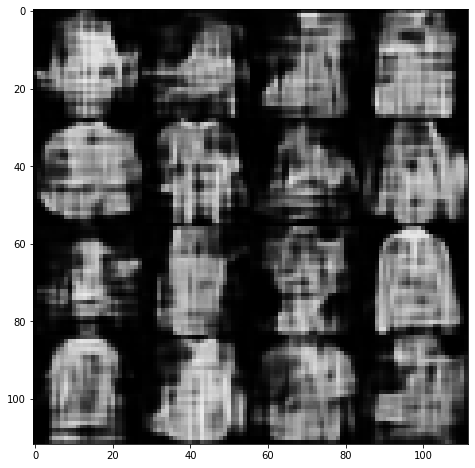

118/118 [==============================] - 36s 302ms/step - loss: 16.1035 - kl_loss: 2.1904 - mse_loss: 13.9131
Epoch 62/100
118/118 [==============================] - 35s 300ms/step - loss: 15.9257 - kl_loss: 2.1905 - mse_loss: 13.7352
Epoch 63/100
118/118 [==============================] - 35s 300ms/step - loss: 15.8255 - kl_loss: 2.1821 - mse_loss: 13.6435
Epoch 64/100
118/118 [==============================] - 35s 300ms/step - loss: 15.8448 - kl_loss: 2.1835 - mse_loss: 13.6613
Epoch 65/100
118/118 [==============================] - 35s 299ms/step - loss: 15.8742 - kl_loss: 2.1876 - mse_loss: 13.6866
Epoch 66/100
118/118 [==============================] - 35s 300ms/step - loss: 15.8197 - kl_loss: 2.1864 - mse_loss: 13.6333
Epoch 67/100
118/118 [==============================] - 35s 300ms/step - loss: 15.8417 - kl_loss: 2.1848 - mse_loss: 13.6569
Epoch 68/100
118/118 [==============================] - 36s 300ms/step - loss: 15.7290 - kl_loss: 2.1843 - mse_loss: 13.5447
Epoch 69/100


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

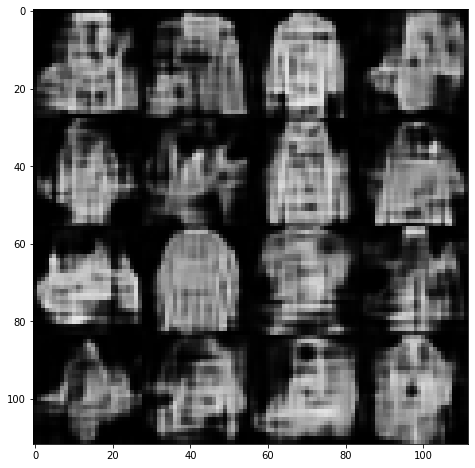

118/118 [==============================] - 36s 302ms/step - loss: 15.8259 - kl_loss: 2.1903 - mse_loss: 13.6356
Epoch 72/100
118/118 [==============================] - 35s 300ms/step - loss: 15.7272 - kl_loss: 2.1831 - mse_loss: 13.5440
Epoch 73/100
118/118 [==============================] - 35s 299ms/step - loss: 15.5829 - kl_loss: 2.1807 - mse_loss: 13.4022
Epoch 74/100
118/118 [==============================] - 35s 300ms/step - loss: 15.7083 - kl_loss: 2.1840 - mse_loss: 13.5243
Epoch 75/100
118/118 [==============================] - 35s 300ms/step - loss: 15.6115 - kl_loss: 2.1833 - mse_loss: 13.4283
Epoch 76/100
118/118 [==============================] - 36s 300ms/step - loss: 15.5036 - kl_loss: 2.1783 - mse_loss: 13.3254
Epoch 77/100
118/118 [==============================] - 35s 300ms/step - loss: 15.5705 - kl_loss: 2.1802 - mse_loss: 13.3903
Epoch 78/100
118/118 [==============================] - 35s 300ms/step - loss: 15.5049 - kl_loss: 2.1782 - mse_loss: 13.3267
Epoch 79/100


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

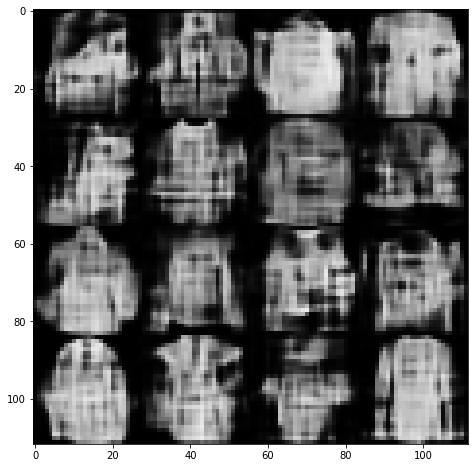

118/118 [==============================] - 36s 301ms/step - loss: 15.4430 - kl_loss: 2.1782 - mse_loss: 13.2647
Epoch 82/100
118/118 [==============================] - 35s 299ms/step - loss: 15.3803 - kl_loss: 2.1782 - mse_loss: 13.2021
Epoch 83/100
118/118 [==============================] - 35s 300ms/step - loss: 15.2817 - kl_loss: 2.1730 - mse_loss: 13.1087
Epoch 84/100
118/118 [==============================] - 35s 299ms/step - loss: 15.2770 - kl_loss: 2.1771 - mse_loss: 13.0999
Epoch 85/100
118/118 [==============================] - 35s 300ms/step - loss: 15.3749 - kl_loss: 2.1789 - mse_loss: 13.1961
Epoch 86/100
118/118 [==============================] - 35s 300ms/step - loss: 15.3707 - kl_loss: 2.1796 - mse_loss: 13.1911
Epoch 87/100
118/118 [==============================] - 36s 300ms/step - loss: 15.2627 - kl_loss: 2.1721 - mse_loss: 13.0906
Epoch 88/100
118/118 [==============================] - 35s 300ms/step - loss: 15.3110 - kl_loss: 2.1753 - mse_loss: 13.1357
Epoch 89/100


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

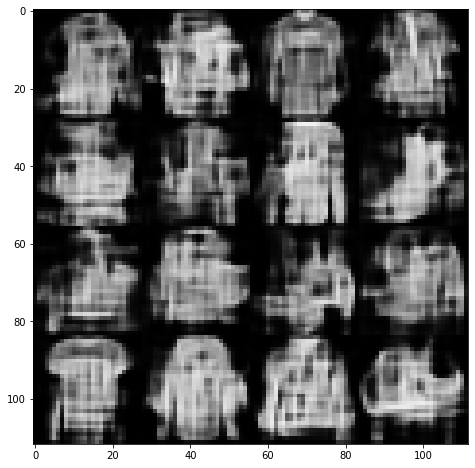

118/118 [==============================] - 36s 302ms/step - loss: 15.2155 - kl_loss: 2.1727 - mse_loss: 13.0429
Epoch 92/100
118/118 [==============================] - 35s 300ms/step - loss: 15.1811 - kl_loss: 2.1739 - mse_loss: 13.0072
Epoch 93/100
118/118 [==============================] - 35s 300ms/step - loss: 15.1092 - kl_loss: 2.1693 - mse_loss: 12.9399
Epoch 94/100
118/118 [==============================] - 35s 299ms/step - loss: 15.1579 - kl_loss: 2.1740 - mse_loss: 12.9839
Epoch 95/100
118/118 [==============================] - 35s 300ms/step - loss: 15.1186 - kl_loss: 2.1706 - mse_loss: 12.9480
Epoch 96/100
118/118 [==============================] - 36s 300ms/step - loss: 15.1884 - kl_loss: 2.1741 - mse_loss: 13.0143
Epoch 97/100
118/118 [==============================] - 35s 300ms/step - loss: 15.0984 - kl_loss: 2.1701 - mse_loss: 12.9283
Epoch 98/100
118/118 [==============================] - 36s 300ms/step - loss: 15.1540 - kl_loss: 2.1780 - mse_loss: 12.9761
Epoch 99/100


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [ ]:
# VAE Method =================================================================
EPOCHS = 100
generator = generative_model(LATENT_SIZE)
vae_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae, encoder = get_autoencoder(IMG_SHAPE, LATENT_SIZE, generator, variable=True)
vae.compile(vae_optimizer)
vae.summary()
callback = ModelMonitor(generator, IMG_SHAPE, LATENT_SIZE, VAE_PATH, 4, 10)
vae.fit(dataset, callbacks=[callback], epochs=EPOCHS)

In [ ]:
vae.save('/content/vae')

INFO:tensorflow:Assets written to: /content/vae/assets


In [ ]:
ae.save('/content/ae')

INFO:tensorflow:Assets written to: /content/ae/assets


In [ ]:
from tensorflow import keras
ae = keras.models.load_model('/content/ae')
ae

In [ ]:
!zip -r /content/content.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/.metricsUUID (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.feature_flags_config.yaml (deflated 23%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.03.23/ (stored 0%)
  adding: content/.config/logs/2022.03.23/14.22.11.024461.log (deflated 54%)
  adding: content/.config/logs/2022.03.23/14.22.10.115472.log (deflated 55%)
  adding: content/.config/logs/2022.03.23/14.21.47.434153.log (deflated 53%)
  adding: content/.config/logs/2022.03.23/14.20.51.700340.log (deflated 90%)
  adding: content/.config/logs/2022.03.23/14.21.37.874736.log (deflated 86%)
  adding: content/.config/logs/2022.03.23/14.21.15.15

In [1]:
!cd .. && rm -rf content && unzip content.zip

Archive:  content.zip
   creating: content/
   creating: content/.config/
 extracting: content/.config/active_config  
 extracting: content/.config/.last_opt_in_prompt.yaml  
 extracting: content/.config/.last_survey_prompt.yaml  
 extracting: content/.config/.metricsUUID  
 extracting: content/.config/gce     
 extracting: content/.config/config_sentinel  
  inflating: content/.config/.feature_flags_config.yaml  
   creating: content/.config/logs/
   creating: content/.config/logs/2022.03.23/
  inflating: content/.config/logs/2022.03.23/14.22.11.024461.log  
  inflating: content/.config/logs/2022.03.23/14.22.10.115472.log  
  inflating: content/.config/logs/2022.03.23/14.21.47.434153.log  
  inflating: content/.config/logs/2022.03.23/14.20.51.700340.log  
  inflating: content/.config/logs/2022.03.23/14.21.37.874736.log  
  inflating: content/.config/logs/2022.03.23/14.21.15.158122.log  
   creating: content/.config/configurations/
  inflating: content/.config/configurations/config_def

In [23]:
# WGAN Method =================================================================
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

# Size of the noise vector
noise_dim = 128

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5


EPOCHS = 20
generator = generative_model(LATENT_SIZE)
generator.summary()
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
wgan = WGAN(
    img_shape=IMG_SHAPE,
    latent_size=LATENT_SIZE,
    generator=generator,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
)
wgan.compile()
callback = ModelMonitor(generator, IMG_SHAPE, LATENT_SIZE, WGAN_PATH, 4, 2)
wgan.fit(dataset, epochs=EPOCHS, callbacks=[callback])

Number of examples: 60000
Shape of the images in the dataset: (28, 28)
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_16 (Dense)            (None, 4096)              524288    
                                                                 
 batch_normalization_32 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_8 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_24 (UpSamplin  (None, 8, 8, 256)     

TypeError: ignored